In [83]:
# Load model directly
from transformers import AutoProcessor, AutoModelForZeroShotImageClassification

processor = AutoProcessor.from_pretrained("Searchium-ai/clip4clip-webvid150k")
model = AutoModelForZeroShotImageClassification.from_pretrained("Searchium-ai/clip4clip-webvid150k")

In [30]:
# Extracting Text Embeddings
import numpy as np
import torch
from transformers import CLIPTokenizer, CLIPTextModelWithProjection


search_sentence = "a person is falling down"

model = CLIPTextModelWithProjection.from_pretrained("Searchium-ai/clip4clip-webvid150k")
tokenizer = CLIPTokenizer.from_pretrained("Searchium-ai/clip4clip-webvid150k")

inputs = tokenizer(text=search_sentence , return_tensors="pt")
outputs = model(input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"])

# Normalize embeddings for retrieval:
final_output = outputs[0] / outputs[0].norm(dim=-1, keepdim=True)
final_output = final_output.cpu().detach().numpy()
text_embeddings = final_output
print(text_embeddings.shape)

# print("final output: \n", final_output)


(1, 512)


In [9]:
# Extracting Video Embeddings
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize, InterpolationMode
from PIL import Image
import cv2
import numpy as np
import torch

# convert one video to few images.  
def video2image(video_path, frame_rate=2, size=224): # 초당 frame_rate 개수로 균등 추출    
    def preprocess(size, n_px):  # 이미지를 전처리하여 텐서로 변환 -> 반환된 텐서는 (추출된 프레임 개수, 채널 수, h, w)의 형태(크기)
        return Compose([
            Resize(size, interpolation=InterpolationMode.BICUBIC),            
            CenterCrop(size),
            lambda image: image.convert("RGB"),
            ToTensor(),
            Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)), # RGB 채널별 평균과 표준편차로 정규화 수행.
        ])(n_px)  # n_px: PIL 이미지 객체
    
    cap = cv2.VideoCapture(video_path, cv2.CAP_FFMPEG)
    frameCount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    if fps < 1:  # FPS가 유효하지 않은 경우, 빈 배열을 반환하고 오류 메시지
        images = np.zeros([3, size, size], dtype=np.float32) 
        print("ERROR: problem reading video file: ", video_path)
    else:
        total_duration = (frameCount + fps - 1) // fps
        start_sec, end_sec = 0, total_duration
        interval = fps / frame_rate
        frames_idx = np.floor(np.arange(start_sec*fps, end_sec*fps, interval))

        ret = True     # 본격적으로 프레임을 읽어와 전처리
        images = np.zeros([len(frames_idx), 3, size, size], dtype=np.float32)
        
        for i, idx in enumerate(frames_idx):
            cap.set(cv2.CAP_PROP_POS_FRAMES , idx)
            ret, frame = cap.read()    
            if not ret: break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)             
            last_frame = i
            images[i,:,:,:] = preprocess(size, Image.fromarray(frame).convert("RGB")) # 읽어온 프레임을 PIL 이미지로 변환한 뒤, 전처리를 거쳐 텐서로 변환. -> images 배열에 저장
            
        images = images[:last_frame+1]
    cap.release()
    video_frames = torch.tensor(images)
    return video_frames

    
vid_example = '/Users/jisu/Desktop/25.상/졸업프로젝트/AIhub-편의점이상-Sample/01.원천데이터/03.이상행동/07.전도/C_3_7_1_BU_SMA_08-30_13-19-19_CC_RGB_DF2_M1.mp4'
video = video2image(vid_example)

In [10]:
video.shape

torch.Size([120, 3, 224, 224])

In [18]:
video.shape

torch.Size([3, 224, 224])

In [33]:
from transformers import CLIPVisionModelWithProjection

model = CLIPVisionModelWithProjection.from_pretrained("Searchium-ai/clip4clip-webvid150k")
model = model.eval()
# # Extracting video embeddings per frame
# video = video.permute(0, 2, 3, 1) # (N, C, H, W) -> (N, H, W, C)
# video = video.to(model.device) # move to GPU
# video_embeddings = []
# for i in range(video.shape[0]):
#     video[i] = video[i].to(model.device) # move to GPU
#     # video[i] = video[i].unsqueeze(0) # add batch dimension
#     with torch.no_grad():
#         video_embeddings.append(model(video[i])["image_embeds"])
# video_embeddings = torch.stack(video_embeddings) # (N, 1, 768)
# video_embeddings = video_embeddings.squeeze(1) # (N, 768)
# # Normalizing the embeddings and calculating mean between all embeddings.
# video_embeddings = video_embeddings / video_embeddings.norm(dim=-1, keepdim=True)
# video_embeddings = torch.mean(video_embeddings, dim=0)
# video_embeddings = video_embeddings / video_embeddings.norm(dim=-1, keepdim=True)
# print(video_embeddings.shape)

visual_output = model(video)

# Normalizing the embeddings and calculating mean between all embeddings. 
visual_output = visual_output["image_embeds"]
visual_output = visual_output / visual_output.norm(dim=-1, keepdim=True)
visual_output = torch.mean(visual_output, dim=0)
visual_output = visual_output / visual_output.norm(dim=-1, keepdim=True)
print(visual_output)

tensor([-2.7121e-02, -3.2603e-02,  2.0232e-02,  6.0055e-02,  1.6490e-02,
         6.4757e-04,  1.4627e-02,  1.1159e-02, -4.6573e-02,  5.5162e-03,
         1.9931e-02, -6.7308e-03,  7.5266e-03,  1.0034e-02,  1.1848e-02,
        -1.3109e-02, -5.1471e-02,  1.1918e-02,  1.7858e-03, -8.9834e-03,
        -7.5532e-02, -8.5189e-03,  1.2312e-02,  1.4048e-02, -6.6083e-02,
         3.6595e-02,  7.7150e-02,  1.2730e-02, -2.1984e-02, -2.8322e-02,
        -1.4181e-03,  4.4522e-02, -1.2353e-02, -5.6600e-02,  5.6986e-02,
        -1.0617e-02, -3.4750e-02, -8.0639e-03,  3.3338e-03, -4.6503e-02,
        -6.7008e-02,  1.7114e-02,  4.6976e-02, -2.8077e-02, -1.3263e-02,
         8.9786e-03, -6.4736e-02, -1.9511e-03,  2.1264e-02, -3.2526e-02,
         2.7339e-02, -5.2238e-02, -2.1553e-03,  1.1082e-02,  7.1944e-03,
         4.3347e-02, -2.1386e-02, -1.1697e-02,  4.9807e-02,  3.0858e-02,
         2.0597e-02, -2.7559e-02, -1.5067e-02,  2.9414e-02, -6.8743e-03,
         4.6964e-03,  3.1279e-02,  2.6731e-01, -2.5

In [13]:
type(text_embeddings)

numpy.ndarray

In [17]:
type(visual_output), len(visual_output), visual_output.shape

(torch.Tensor, 512, torch.Size([512]))

In [34]:
# Calculate similarity  between text and video
similarity = []

for i in range(visual_output.shape[0]):
    similarity.append(np.dot(text_embeddings, visual_output[i]))
    print("Similarity between text and video frame {}: {}".format(i, similarity[i]))

# Calculate similarity

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [53]:
text_embeddings.shape

(1, 512)

In [54]:
visual_embeddings = visual_output.unsqueeze(0) # 토치텐서에 특정 차원을 추가하는 데 사용되는 함수
visual_embeddings.shape

torch.Size([1, 512])

In [36]:
visual_output.shape

torch.Size([512])

In [61]:
type(text_embeddings), type(visual_output)

(numpy.ndarray, torch.Tensor)

In [63]:
text_tensor = torch.Tensor(text_embeddings)
type(text_tensor)

torch.Tensor

In [64]:
# sim_matrix = np.matmul(text_embeddings, visual_embeddings.T)
sim_matrix = torch.matmul(text_tensor, visual_output.T)
print("Similarity matrix shape: ", sim_matrix.shape)

Similarity matrix shape:  torch.Size([1])


In [66]:
sim_matrix

tensor([0.1502], grad_fn=<MvBackward0>)

In [46]:
visual_np = visual_output.cpu().detach().numpy()
print(visual_np.shape)
type(visual_np)

(512,)


numpy.ndarray

In [65]:
print(text_embeddings.shape)
# type(text_embeddings) # numpy.ndarray

text_embeddings.squeeze().shape

(1, 512)


(512,)

In [ ]:
np.dot(text_embeddings.squeeze(), visual_np[0])


In [ ]:
text_tensor = torch.from_numpy(text_embeddings)

In [44]:
text_tensor = text_tensor.squeeze(0)
text_tensor.shape

torch.Size([512])

In [45]:
np.dot(text_tensor, visual_output)

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [111]:
import cv2
import numpy as np
import tempfile
from collections import deque
from torchvision import transforms

# 비디오 파일을 처리하고 임베딩을 생성하는 함수
def process_video(video_file, model, window_size=6, time_interval=0.5, progress_callback=None):
    """
    비디오에서 프레임을 추출하고, 모델을 사용하여 임베딩을 생성하는 함수.

    Args:
        video_file (file-like object): 입력 비디오 파일
        model (torch.nn.Module): 프레임 임베딩을 생성할 모델
        window_size (int, optional): 입력 영상의 프레임 수 (기본값: 6)
        time_interval (float, optional): 샘플링할 시간 간격 (초 단위, 기본값: 0.5초)
        progress_callback (function, optional): 진행률 업데이트를 위한 콜백 함수

    Returns:
        tuple: (expanded_embeddings_array, fps)
            - expanded_embeddings_array (np.ndarray): (total_frames, 512) 크기의 임베딩 배열
    """
    # 비디오 파일의 총 프레임 수와 FPS를 가져옴
    cap = cv2.VideoCapture(str(video_file))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    frame_interval = int(fps * time_interval)
    
    frame_queue = deque(maxlen=window_size)
    embeddings = []

    preprocess = transforms.Compose([
        transforms.ToPILImage(),  # numpy 이미지 → PIL
        transforms.Resize((224, 224)),
        transforms.ToTensor(),  # [0, 255] → [0.0, 1.0]
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
    ])
    
    
    for frame_idx in range(total_frames):
        ret, video_frame = cap.read()
        if not ret:
            break
        if frame_idx % frame_interval == 0:
            video_frame = cv2.cvtColor(video_frame, cv2.COLOR_BGR2RGB)
            while len(frame_queue) < window_size:
                frame_queue.append(video_frame)
            frame_queue.append(video_frame)
            frame_tensor = preprocess(video_frame).unsqueeze(0)  # (1, 3, 224, 224)
            vis_vector = model(frame_tensor[frame_idx])
            vis_vector = vis_vector.squeeze(1)
            vis_vector = vis_vector / vis_vector.norm(dim=-1, keepdim=True)
            if vis_vector.shape == (1, 512):
                embeddings.append(vis_vector[0].cpu().numpy().astype(np.float32))
        # 진행률 업데이트: 현재 처리한 프레임 (frame_idx+1) / 전체 프레임
        if progress_callback is not None:
            progress_callback(frame_idx + 1, total_frames)
    
    cap.release()
    
    if len(embeddings) == 0: # 임베딩이 생성되지 않은 경우
        raise ValueError("임베딩이 생성되지 않았습니다. 비디오 또는 모델을 확인하세요.")
    
    # 선형 보간을 이용해 전체 프레임 크기의 임베딩 배열 생성
    sample_indices = np.arange(len(embeddings)) * frame_interval
    full_indices = np.arange(total_frames)
    E = np.array(embeddings)
    expanded_embeddings_array = np.zeros((total_frames, E.shape[1]), dtype=E.dtype)
    for d in range(E.shape[1]):
        expanded_embeddings_array[:, d] = np.interp(full_indices, sample_indices, E[:, d])
    
    return expanded_embeddings_array

### **프레임(sparse) 단위 처리**

In [16]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Device: ", device)

vid_example = '/Users/jisu/Desktop/25.상/졸업프로젝트/Sample/01.원천데이터/03.이상행동/07.전도/C_3_7_1_BU_SMA_08-30_13-19-19_CC_RGB_DF2_M1.mp4'
video = video2image(vid_example)
video.shape

Device:  cpu
ERROR: problem reading video file:  /Users/jisu/Desktop/25.상/졸업프로젝트/Sample/01.원천데이터/03.이상행동/07.전도/C_3_7_1_BU_SMA_08-30_13-19-19_CC_RGB_DF2_M1.mp4


[ WARN:0@371.786] global cap.cpp:206 open VIDEOIO(FFMPEG): backend is generally available but can't be used to capture by name


torch.Size([3, 224, 224])

In [12]:
video.shape

torch.Size([3, 224, 224])

In [ ]:
from transformers import CLIPVisionModelWithProjection

model = CLIPVisionModelWithProjection.from_pretrained("Searchium-ai/clip4clip-webvid150k")
model = model.eval()

video_file = '/Users/jisu/Desktop/25.상/졸업프로젝트/AIhub-편의점이상-Sample/01.원천데이터/03.이상행동/07.전도/C_3_7_1_BU_SMA_08-30_13-19-19_CC_RGB_DF2_M1.mp4'
video = video2image(video_file)
print(video.shape) # torch.Size([120, 3, 224, 224])

# Extracting video embeddings per frame
# video = video.permute(0, 2, 3, 1) # (N, C, H, W) -> (N, H, W, C)
    # CLIP 모델 pixel_values 입력, (N, 3, 224, 224) 형식
video = video.to(model.device) # move to GPU

video_embeddings = []
for i in range(video.shape[0]):
    video[i] = video[i].to(model.device) # move to GPU
    # video[i] = video[i].unsqueeze(0) # add batch dimension
    with torch.no_grad():
        # video_embeddings.append(model(video[i])["image_embeds"])
        video_embeddings.append(model(pixel_values=video)["image_embeds"])

video_embeddings = torch.stack(video_embeddings) # (N, 1, 768)
video_embeddings = video_embeddings.squeeze(1) # (N, 768)


# Normalizing the embeddings and calculating mean between all embeddings.
video_embeddings = video_embeddings / video_embeddings.norm(dim=-1, keepdim=True)
video_embeddings = torch.mean(video_embeddings, dim=0)
video_embeddings = video_embeddings / video_embeddings.norm(dim=-1, keepdim=True)


print(video_embeddings.shape) # torch.Size([120, 512])-> cpu연산으로 12분 10초 소요

torch.Size([120, 3, 224, 224])
torch.Size([120, 512])


In [36]:
# Extracting Text Embeddings
import numpy as np
import torch
from transformers import CLIPTokenizer, CLIPTextModelWithProjection


search_sentence = "a person is singing"

model = CLIPTextModelWithProjection.from_pretrained("Searchium-ai/clip4clip-webvid150k")
tokenizer = CLIPTokenizer.from_pretrained("Searchium-ai/clip4clip-webvid150k")

inputs = tokenizer(text=search_sentence , return_tensors="pt")
outputs = model(input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"])

# Normalize embeddings for retrieval:
final_output = outputs[0] / outputs[0].norm(dim=-1, keepdim=True)
print(final_output.shape) # torch.Size([1, 512])

text_embeddings = final_output.cpu().detach().numpy()
text_embeddings.shape

torch.Size([1, 512])


(1, 512)

In [37]:
import matplotlib.pyplot as plt

# 코사인 유사도 계산: 각 프레임과 텍스트 사이
# 결과: [120]
similarities = torch.matmul(video_embeddings, final_output.T).squeeze(1)  # (120, 1) -> (120,)
similarities.shape

torch.Size([120])

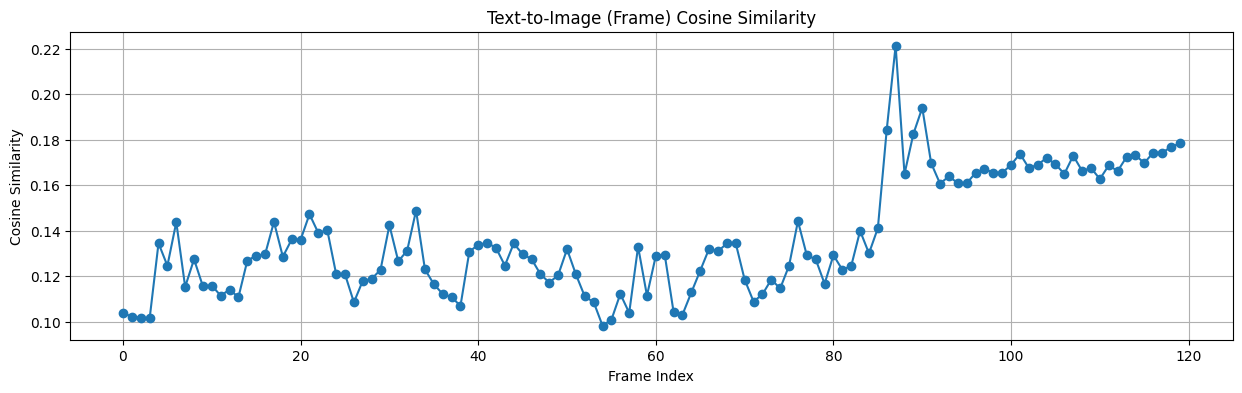

In [31]:
plt.figure(figsize=(15, 4))
plt.plot(similarities.detach().numpy(), marker='o')
plt.title("Text-to-Image (Frame) Cosine Similarity")
plt.xlabel("Frame Index")
plt.ylabel("Cosine Similarity")
plt.grid(True)
plt.show()

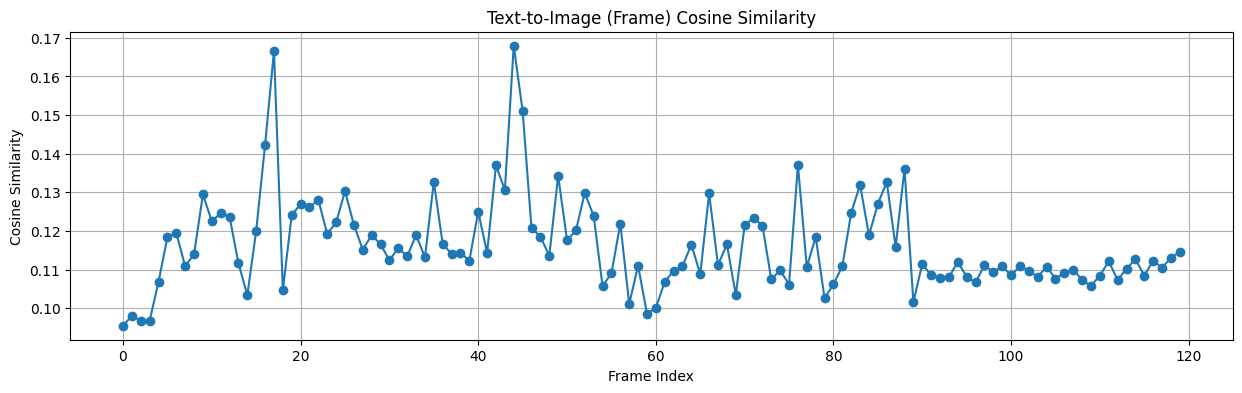

In [38]:
plt.figure(figsize=(15, 4))
plt.plot(similarities.detach().numpy(), marker='o')
plt.title("Text-to-Image (Frame) Cosine Similarity")
plt.xlabel("Frame Index")
plt.ylabel("Cosine Similarity")
plt.grid(True)
plt.show()

In [35]:
mean_pooled_visual_output = torch.mean(video_embeddings, dim=0)             # mean of all embeddings: torch.Size([512])
mean_pooled_visual_output = mean_pooled_visual_output / mean_pooled_visual_output.norm(dim=-1, keepdim=True) # normalizing the embeddings: torch.Size([512])

# Calculate similarity between text and video
similarity = torch.dot(final_output.squeeze(), mean_pooled_visual_output)
similarity

tensor(0.1502, grad_fn=<DotBackward0>)

1. 프레임을 전처리하고 텐서로 변환

In [109]:
from torchvision import transforms

preprocess = transforms.Compose([
    transforms.ToPILImage(),  # numpy 이미지 → PIL
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # [0, 255] → [0.0, 1.0]
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

2. 단일 프레임을 텐서로 변환하고 배치 차원 추가


In [72]:
# numpy 프레임 → torch.Tensor로 변환
frame_tensor = preprocess(video_frames).unsqueeze(0).to(device)  # (1, 3, 224, 224)

# 모델에 입력
with torch.no_grad():
    vis_vector = model(pixel_values=frame_tensor).image_embeds  # CLIPVisionModelWithProjection


ValueError: pic should be 2/3 dimensional. Got 4 dimensions.

In [84]:
video_embeddings, _ = process_video(vid_example, model, window_size=6, time_interval=0.5)

0


OpenCV: Couldn't read video stream from file "/Users/jisu/Desktop/25.상/졸업프로젝트/Sample/01.원천데이터/03.이상행동/07.전도/C_3_7_1_BU_SMA_08-30_13-19-19_CC_RGB_DF2_M1.mp4"


ValueError: 임베딩이 생성되지 않았습니다. 비디오 또는 모델을 확인하세요.